# Using sklearn to predict used car prices

In this jupyter notebook, I will use the data set found here on Kaggle (https://www.kaggle.com/datasets/harikrishnareddyb/used-car-price-predictions?select=true_car_listings.csv) to predict the price of used cars. Through the use of this analysis, one could identify possible bargains on used cars by predicting the price of a car using the model and comparing that to what the car is actually being sold for. Whenever my algorithm predicts that a car is worth more than what it is actually selling for, this presents a possible opportunity to go "bargain hunting".

I model the data with four different machine learning algorithms: decision tree regression, random forest regression, k-nearest neighbors regression, and a neural network. In the comparison section, I compare the three methods to see which performs the best.

This analysis is structured as follows:

1. Data Loading and Exploration

2. Data Cleaning and Preparation

3. Decision Tree Regression Analysis

4. Random Forest Regression Analysis

5. KNN (k-nearest neighbors) Regression

6. Neural Network

7. Comparison/Conclusions

### 1. Data Loading and Exploration 

We begin by loading in any libraries we need as well as the data from a csv file. For the purposes of staying within a reasonable computation time, we use just the first 5,000 data entries.

In [61]:
%%capture

import pandas as pd
import sklearn as skl
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as exp
import numpy as np

data = pd.read_csv('true_car_listings.csv')
shuffled = shuffle(data)
data = shuffled.iloc[:5000, :]

Let's take a look at our data

In [62]:
print('Data shape = ', data.shape)
data.head

Data shape =  (5000, 8)


<bound method NDFrame.head of         Price  Year  Mileage             City State                Vin  \
36067   29345  2014    32318           Naples    FL  WBA3A9G58ENS64705   
282996  13000  2007    65127          Liberal    KS  1ZVFT82H775292291   
248442  16800  2016    41898       Santa Rosa    CA  3FA6P0K92GR343801   
631933  10969  2015    32596          Phoenix    AZ  1N4AL3AP0FN338959   
200446  25999  2015     9140     New Richmond    WI  2C4RC1CG8FR521091   
...       ...   ...      ...              ...   ...                ...   
693496  26750  2015    28266          Turlock    CA  JN1AZ4EH7FM443900   
84568   11990  2014    37150          Batavia    NY  1G11B5SL2EF121676   
509488  28890  2016    17544            Miami    FL  1C4BJWDG9GL266593   
50681   26989  2009    58927  Saint Augustine    FL  WBSWD93519P361051   
16978   31000  2016    33630        Manalapan    NJ  WAUM2AFR0GA008558   

             Make           Model  
36067         BMW               3  
282996   

The first thing we notice is the shape of our data. Our data has 8 features and 5,000 rows. This means we have 5,000 total used cars to work with.

We also notice that we have categorical data in some cases. City, State, Make, and Model are all categorical variables. Our models don't work with categorical variables, so a little later will use one-hot encoding to turn these into numerical variables. Also later, we will drop the VIN column because every VIN number is unique and unordered. Therefore, the VIN number provides us with no useful information.

Before we do this, however, let's try to visualize the numerical data that we have. This is contained in the "year" and "mileage" columns.

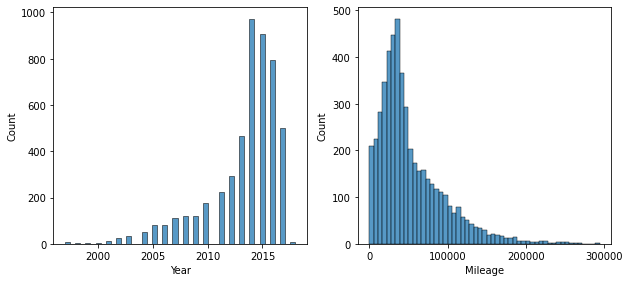

In [63]:
num_cols = ["Year", "Mileage"]
plt.figure(figsize=(10,20))
for index,i in enumerate(num_cols):
    plot = plt.subplot(4,2,index+1)
    sns.histplot(data[i])
    if i=='Mileage':
        plot.set(xticks=np.arange(0, 350000, 100000))

### 2. Data Cleaning and Preparation

Now let's do some data cleaning. As mentioned earlier, let's start by simply dropping the Vin column.

In [64]:
#Drop VIN
data = data.drop("Vin", axis=1)

For our categorical variables, we need to turn them into numerical variables somehow. To do this, we'll use one-hot encoding, where each possible value for the variable gets its own column, and the entry in that column is always either zero or one.

In [65]:
#Get the dummy variables for City, State, Make, and Model
dummy_city = pd.get_dummies(data['City'])
dummy_state = pd.get_dummies(data['State'])
dummy_make = pd.get_dummies(data['Make'])
dummy_model = pd.get_dummies(data['Model'])

In [66]:
#Use one-hot encoding for each of the categorical variables
data = pd.concat([data, dummy_city], axis=1).drop('City', axis=1)
data = pd.concat([data, dummy_state], axis=1).drop('State', axis=1)
data = pd.concat([data, dummy_make], axis=1).drop('Make', axis=1)
data = pd.concat([data, dummy_model], axis=1).drop('Model', axis=1)

Now that we've implemented the one-hot encoding, let's see our data shape and the first few rows of the data.

In [67]:
print("data shape = ", data.shape)
data.head()

data shape =  (5000, 2555)


,Price,Year,Mileage,AUSTIN,AVON,Aberdeen,Abilene,Abington,Acton,Acworth,...,fortwopure,i3Hatchback,iAAutomatic,iQ3dr,tC2dr,tC3dr,tCAutomatic,xB5dr,xBManual,xD5dr
36067,29345,2014,32318,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282996,13000,2007,65127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248442,16800,2016,41898,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
631933,10969,2015,32596,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200446,25999,2015,9140,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see that our data has expanded to look like it has 2,555 features! This is because there's probably many different cities, makes, and models in our data. With one-hot encoding, each unique value for a categorical variable becomes its own feature (column). That's why we see, for instance, "Austin" as a column where most of the values are going to be zero, but if a car was bought in Austin, then it will have a one in that column. Now that our categorical data has effectively been turned into numerical data, we can use it to train our models!

To use our data for our models, we must manually split our data into the independent and dependent vaiables. We will call the independent variables (make, model, mileage, etc) X, and the dependent variable (price) y. Once we have X and y, we will split our data into testing and training data sets using the train_test_split function.

In [69]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size = 0.25, random_state = 5)

We're now ready to train our models!

### 3. Decision Tree Regression

First we create and train our decision tree on our training data.

In [87]:
tree = DecisionTreeRegressor(min_samples_split=15)
tree.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_split=15)

Now that our model is trained, let's try to visualize the predictions it makes by graphing the predicted price by our model against the true price for our testing data set. We'll also graph a straight line on the graph corresponding to a "perfect price prediction".

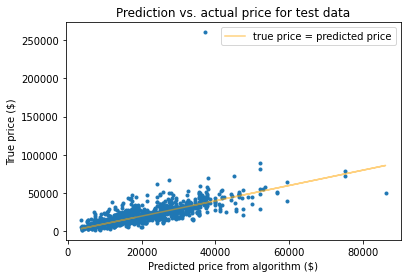

In [88]:
preds = tree.predict(X_test)

plt.figure()
plt.xlabel('Predicted price from algorithm ($)')
plt.ylabel('True price ($)')
plt.title('Prediction vs. actual price for test data')
plt.plot(preds, y_test, '.')
plt.plot(preds, preds, c='orange', alpha=0.5, label='true price = predicted price')
plt.legend()

Visually, except for a couple outliers, this looks pretty good! Naturally, the prices are clumped near the low end because there just aren't that many used cars for sale in the $80,000 range. To get a more quantitative view of the accuracy of our model, let's compute some accuracy metrics and organize them in a pandas dataframe.

In [125]:
Results = pd.DataFrame(columns=["Model","Train R2","Test R2","Test RMSE","Variance","Test MAPE"])


r2_dt = skl.metrics.r2_score(y_test,preds)
dt_train_pred = tree.predict(X_train)
r2_train_dt = skl.metrics.r2_score(y_train, dt_train_pred)
rmse_dt = np.sqrt(skl.metrics.mean_squared_error(y_test, preds))
mape_dt = skl.metrics.mean_absolute_percentage_error(y_test, preds)
variance_dt = r2_train_dt - r2_dt
Results = Results.append({"Model":"Decision Tree (Squared Error Criterion)","Train R2":r2_train_dt,"Test R2":r2_dt,"Test RMSE":rmse_dt,"Variance":variance_dt, "Test MAPE":mape_dt},ignore_index=True)

In [126]:
Results

,Model,Train R2,Test R2,Test RMSE,Variance,Test MAPE
0,Decision Tree (Squared Error Criterion),0.945699,0.500591,9394.990453,0.445108,0.252675


Okay, so our average percentage error is a little worse than 25%. Let's see if we can improve the results by switching the criterion in our DecisionTreeRegressor object (the default is squared error). We'll try out all three other options. These are 'Friedman_mse', 'absolute_error' and 'poisson'. Let's create these different decision trees, train them on our data and then make the same plots and table as above.

In [121]:
%%capture

tree_fmse = DecisionTreeRegressor(criterion='friedman_mse', min_samples_split=15)
tree_fmse.fit(X_train, y_train)

tree_ae = DecisionTreeRegressor(criterion='absolute_error', min_samples_split=15)
tree_ae.fit(X_train, y_train)

tree_p = DecisionTreeRegressor(criterion='poisson', min_samples_split=15)
tree_p.fit(X_train, y_train)

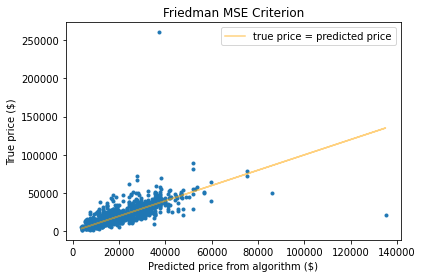

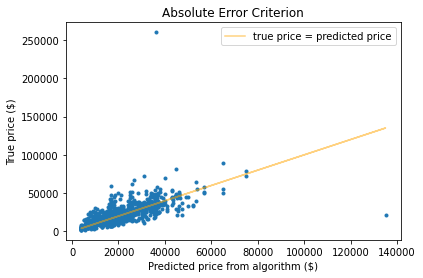

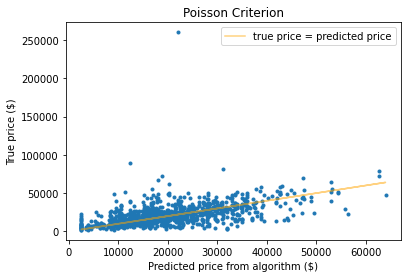

In [122]:
preds_fmse = tree_fmse.predict(X_test)

plt.figure()
plt.xlabel('Predicted price from algorithm ($)')
plt.ylabel('True price ($)')
plt.title('Friedman MSE Criterion')
plt.plot(preds_fmse, y_test, '.')
plt.plot(preds_fmse, preds_fmse, c='orange', alpha=0.5, label='true price = predicted price')
plt.legend()



preds_ae = tree_ae.predict(X_test)

plt.figure()
plt.xlabel('Predicted price from algorithm ($)')
plt.ylabel('True price ($)')
plt.title('Absolute Error Criterion')
plt.plot(preds_ae, y_test, '.')
plt.plot(preds_ae, preds_ae, c='orange', alpha=0.5, label='true price = predicted price')
plt.legend()



preds_p = tree_p.predict(X_test)

plt.figure()
plt.xlabel('Predicted price from algorithm ($)')
plt.ylabel('True price ($)')
plt.title('Poisson Criterion')
plt.plot(preds_p, y_test, '.')
plt.plot(preds_p, preds_p, c='orange', alpha=0.5, label='true price = predicted price')
plt.legend()

Visually, these all look pretty similar, but the poisson criterion seems to have done a bit worse. Let's confirm this by expanding our results table that we had above to include these different methods.

In [127]:
r2_dt_fmse = skl.metrics.r2_score(y_test,preds_fmse)
dt_fmse_train_pred = tree_fmse.predict(X_train)
r2_train_dt_fmse = skl.metrics.r2_score(y_train, dt_fmse_train_pred)
rmse_dt_fmse = np.sqrt(skl.metrics.mean_squared_error(y_test, preds_fmse))
mape_dt_fmse = skl.metrics.mean_absolute_percentage_error(y_test, preds_fmse)
variance_dt_fmse = r2_train_dt_fmse - r2_dt_fmse
Results = Results.append({"Model":"Decision Tree (Friedman MSE Criterion)","Train R2":r2_train_dt_fmse,"Test R2":r2_dt_fmse,"Test RMSE":rmse_dt_fmse,"Variance":variance_dt_fmse, "Test MAPE":mape_dt_fmse},ignore_index=True)

r2_dt_ae = skl.metrics.r2_score(y_test,preds_ae)
dt_ae_train_pred = tree_ae.predict(X_train)
r2_train_dt_ae = skl.metrics.r2_score(y_train, dt_ae_train_pred)
rmse_dt_ae = np.sqrt(skl.metrics.mean_squared_error(y_test, preds_ae))
mape_dt_ae = skl.metrics.mean_absolute_percentage_error(y_test, preds_ae)
variance_dt_ae = r2_train_dt_ae - r2_dt_ae
Results = Results.append({"Model":"Decision Tree (Absolute Error Criterion)","Train R2":r2_train_dt_ae,"Test R2":r2_dt_ae,"Test RMSE":rmse_dt_ae,"Variance":variance_dt_ae, "Test MAPE":mape_dt_ae},ignore_index=True)

r2_dt_p = skl.metrics.r2_score(y_test,preds_p)
dt_p_train_pred = tree_p.predict(X_train)
r2_train_dt_p = skl.metrics.r2_score(y_train, dt_p_train_pred)
rmse_dt_p = np.sqrt(skl.metrics.mean_squared_error(y_test, preds_p))
mape_dt_p = skl.metrics.mean_absolute_percentage_error(y_test, preds_p)
variance_dt_p = r2_train_dt_p - r2_dt_p
Results = Results.append({"Model":"Decision Tree (Poisson Criterion)","Train R2":r2_train_dt_p,"Test R2":r2_dt_p,"Test RMSE":rmse_dt_p,"Variance":variance_dt_p, "Test MAPE":mape_dt_p},ignore_index=True)

In [128]:
Results

,Model,Train R2,Test R2,Test RMSE,Variance,Test MAPE
0,Decision Tree (Squared Error Criterion),0.945699,0.500591,9394.990453,0.445108,0.252675
1,Decision Tree (Friedman MSE Criterion),0.945699,0.443710,9915.589121,0.501989,0.254839
2,Decision Tree (Absolute Error Criterion),0.929971,0.435632,9987.321617,0.494339,0.239625
3,Decision Tree (Poisson Criterion),0.868214,0.227740,11682.877047,0.640474,0.389350


We see that the absolute error option for the criterion is the best. The Poisson criterion also does considerably worse than all the rest of the criterion which is interesting to note.

### 4. Random Forest Regression

Now let's try the same analysis, but with a random forest regressor. This method uses many randomized decision trees to lower the variance of the output. Thus, we should find that the random forest regresor gives a lower mean absolute percentage error than even our best decision tree model. Let's see this in action. We set everything up just the same as before. We will use max_features as the square root of our total number of features.

In [129]:
num_features = X_train.shape[1]
forest = RandomForestRegressor(max_features = int(round(np.sqrt(num_features))))
forest.fit(X_train, y_train)

RandomForestRegressor(max_features=51)

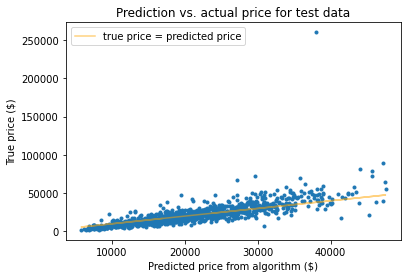

In [130]:
preds_forest = forest.predict(X_test)

plt.figure()
plt.xlabel('Predicted price from algorithm ($)')
plt.ylabel('True price ($)')
plt.title('Prediction vs. actual price for test data')
plt.plot(preds_forest, y_test, '.')
plt.plot(preds_forest, preds_forest, c='orange', alpha=0.5, label='true price = predicted price')
plt.legend()

I'd say that this visually looks like it is better than our decision tree model from above. Let's calculate all of our metrics and add the results to our table.

In [131]:
r2_forest = skl.metrics.r2_score(y_test,preds_forest)
forest_train_pred = forest.predict(X_train)
r2_train_forest = skl.metrics.r2_score(y_train, forest_train_pred)
rmse_forest = np.sqrt(skl.metrics.mean_squared_error(y_test, preds_forest))
mape_forest = skl.metrics.mean_absolute_percentage_error(y_test, preds_forest)
variance_forest = r2_train_forest - r2_forest
Results = Results.append({"Model":"Random Forest","Train R2":r2_train_forest,"Test R2":r2_forest,"Test RMSE":rmse_forest,"Variance":variance_forest, "Test MAPE":mape_forest},ignore_index=True)

In [132]:
Results

,Model,Train R2,Test R2,Test RMSE,Variance,Test MAPE
0,Decision Tree (Squared Error Criterion),0.945699,0.500591,9394.990453,0.445108,0.252675
1,Decision Tree (Friedman MSE Criterion),0.945699,0.443710,9915.589121,0.501989,0.254839
2,Decision Tree (Absolute Error Criterion),0.929971,0.435632,9987.321617,0.494339,0.239625
3,Decision Tree (Poisson Criterion),0.868214,0.227740,11682.877047,0.640474,0.389350
4,Random Forest,0.946835,0.551743,8900.850818,0.395092,0.251918


Indeed, our random forest does better than the decision tree, although not by much. We still have around a 25% mean absolute percentage error.

### 5. K-Nearest Neighbors Regression

The final regression method I will try out is k-nearest neighbors. This method should do well, but one could worry about the one-hot encoding that we did messing this up. By this, I mean that it is possible that k-nearest neighbors could "overweight" or "underweight" the features which were one-hot encoded. This is because the one-hot encoded features are not actually numerical, they are categorical. K-nearest neighbors relies on numerical data to calculate distances between our cars in the parameter space. Thus the different normalizations of each of our parameters could be a concern. Let's try it out and see how we do.

First, let's figure out what we want to use as the k_neighbors argument. The algorithm will by default take the average of the 5 nearest neighbors to guess a price for each car. Our data set has a total of 5,000 cars, so the default of 5 is probably too small. Let's do a short analysis to find the optimal value for n_neighbors.

In [133]:
num_k = 100
k_arr = np.zeros([num_k, 2])

for index in np.arange(num_k-1)+1:
    knn = KNeighborsRegressor(n_neighbors=index*(int(X_train.shape[0]/num_k)))
    knn.fit(X_train, y_train)
    iter_preds = knn.predict(X_test)
    ape = skl.metrics.mean_absolute_percentage_error(y_test, iter_preds)
    k_arr[index, :] = [index*(int(data.shape[0]/num_k)), ape]
    
#Get rid of first column, which never got updated
k_arr = np.delete(k_arr, 0, 0)

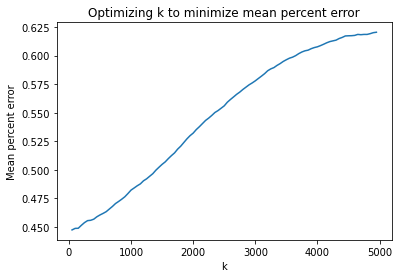

In [134]:
plt.figure()
plt.xlabel('k')
plt.ylabel('Mean percent error')
plt.title('Optimizing k to minimize mean percent error')
plt.plot(k_arr[:,0], k_arr[:,1])

This plot appears to have a minimum at the lowest possible k, but let's zoom in on the low-k region of the graph to make sure.

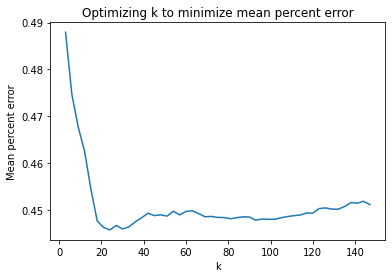

In [136]:
num_k = 50
k_arr = np.zeros([num_k, 2])

for index in np.arange(num_k-1)+1:
    knn = KNeighborsRegressor(n_neighbors=index*3)
    knn.fit(X_train, y_train)
    iter_preds = knn.predict(X_test)
    ape = skl.metrics.mean_absolute_percentage_error(y_test, iter_preds)
    k_arr[index, :] = [index*3, ape]
    
#Get rid of first column, which never got updated
k_arr = np.delete(k_arr, 0, 0)


plt.figure()
plt.xlabel('k')
plt.ylabel('Mean percent error')
plt.title('Optimizing k to minimize mean percent error')
plt.plot(k_arr[:,0], k_arr[:,1])

This graph appears to have a minimum near k = 30, so let's use that as our num_neighbors argument.

In [137]:
knn = KNeighborsRegressor(n_neighbors=30)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=30)

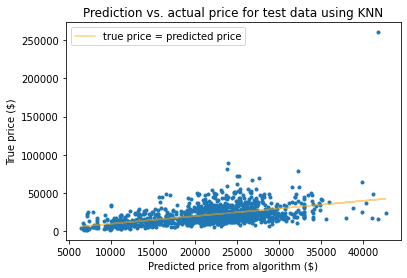

In [138]:
preds_knn = knn.predict(X_test)

plt.figure()
plt.xlabel('Predicted price from algorithm ($)')
plt.ylabel('True price ($)')
plt.title('Prediction vs. actual price for test data using KNN')
plt.plot(preds_knn, y_test, '.')
plt.plot(preds_knn, preds_knn, c='orange', alpha=0.5, label='true price = predicted price')
plt.legend()

This looks pretty good, but let's see how it compares to our other models.

In [139]:
r2_knn = skl.metrics.r2_score(y_test,preds_knn)
knn_train_pred = knn.predict(X_train)
r2_train_knn = skl.metrics.r2_score(y_train, knn_train_pred)
rmse_knn = np.sqrt(skl.metrics.mean_squared_error(y_test, preds_knn))
mape_knn = skl.metrics.mean_absolute_percentage_error(y_test, preds_knn)
variance_knn = r2_train_knn - r2_knn
Results = Results.append({"Model":"K-Nearest Neighbors","Train R2":r2_train_knn,"Test R2":r2_knn,"Test RMSE":rmse_knn,"Variance":variance_knn, "Test MAPE":mape_knn},ignore_index=True)

In [140]:
Results

,Model,Train R2,Test R2,Test RMSE,Variance,Test MAPE
0,Decision Tree (Squared Error Criterion),0.945699,0.500591,9394.990453,0.445108,0.252675
1,Decision Tree (Friedman MSE Criterion),0.945699,0.443710,9915.589121,0.501989,0.254839
2,Decision Tree (Absolute Error Criterion),0.929971,0.435632,9987.321617,0.494339,0.239625
3,Decision Tree (Poisson Criterion),0.868214,0.227740,11682.877047,0.640474,0.389350
4,Random Forest,0.946835,0.551743,8900.850818,0.395092,0.251918
5,K-Nearest Neighbors,0.251188,0.205761,11847.958463,0.045427,0.445985


While the K-nearest neighbors looked pretty good visually, we see that it is actually our worst model yet! I explain in more detail why I think this is in the conclusions/comparison section. For now, let's move on to our final model, the neural network.

### 6. Neural Network

Let's create a neural network with 7 total layers, one being and input and one being an output layer. All of the hidden layers will start large and gradually decrease in size.

In [144]:
X_train.shape

(3750, 2554)

In [145]:
input_shape = X_train.shape[1]

nn = keras.Sequential(
    [
        layers.Dense(units=64, activation="relu", input_shape=(input_shape,)),
        layers.Dense(units=32, activation="relu", input_shape=(int(input_shape/10),)),
        layers.Dense(units=16, activation="relu", input_shape=(int(input_shape/10),)),
        layers.Dense(units=8, activation="relu", input_shape=(int(input_shape/10),)),
        layers.Dense(units=4, activation="relu", input_shape=(int(input_shape/10),)),
        layers.Dense(units=2, activation="relu", input_shape=(int(input_shape/10),)),
        layers.Dense(units=1),
    ]
)

We can see a summary of our neural network architecture below.

In [147]:
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                163520    
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

Now we need to compile our model. We'll use the "Adam" optimizer and mean absolute error as our loss function that the network will minimize as it is training. After compilation, we train our model with the data.

In [148]:
%%capture

nn.compile(optimizer='adam', loss='mae')
nn.fit(x=np.array(X_train, dtype='float'), y=np.array(y_train, dtype='float'), batch_size=int(X_train.shape[0]/10), epochs=500)

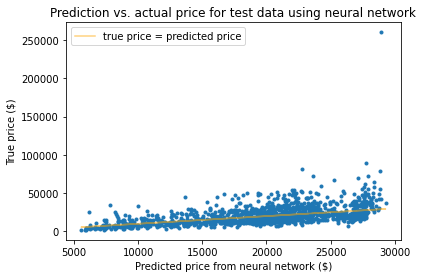

In [149]:
preds_nn = nn.predict(X_test)

plt.figure()
plt.xlabel('Predicted price from neural network ($)')
plt.ylabel('True price ($)')
plt.title('Prediction vs. actual price for test data using neural network')
plt.plot(preds_nn, y_test, '.')
plt.plot(preds_nn, preds_nn, c='orange', alpha=0.5, label='true price = predicted price')
plt.legend()

Finally, let's add the neural network to our table and see how it compares.

In [150]:
r2_nn = skl.metrics.r2_score(y_test,preds_nn)
nn_train_pred = nn.predict(X_train)
r2_train_nn = skl.metrics.r2_score(y_train, nn_train_pred)
rmse_nn = np.sqrt(skl.metrics.mean_squared_error(y_test, preds_nn))
mape_nn = skl.metrics.mean_absolute_percentage_error(y_test, preds_nn)
variance_nn = r2_train_nn - r2_nn
Results = Results.append({"Model":"Neural Network","Train R2":r2_train_nn,"Test R2":r2_nn,"Test RMSE":rmse_nn,"Variance":variance_nn, "Test MAPE":mape_nn},ignore_index=True)

In [151]:
Results

,Model,Train R2,Test R2,Test RMSE,Variance,Test MAPE
0,Decision Tree (Squared Error Criterion),0.945699,0.500591,9394.990453,0.445108,0.252675
1,Decision Tree (Friedman MSE Criterion),0.945699,0.443710,9915.589121,0.501989,0.254839
2,Decision Tree (Absolute Error Criterion),0.929971,0.435632,9987.321617,0.494339,0.239625
3,Decision Tree (Poisson Criterion),0.868214,0.227740,11682.877047,0.640474,0.389350
4,Random Forest,0.946835,0.551743,8900.850818,0.395092,0.251918
5,K-Nearest Neighbors,0.251188,0.205761,11847.958463,0.045427,0.445985
6,Neural Network,0.258943,0.223248,11716.802223,0.035695,0.366065


We see that our neural network is better than K-Nearest Neighbors and the decision tree with Poisson criterion, but worse than the other decision trees as well as the random forest.

### 7. Comparison/Conclusions

In this notebook, we ran algorithms using sklearn to try to predict used car prices. We used decision trees with various criteria, a random forest, a k-nearest neighbors algorithm, and a neural network. The results are summarized in the table below.

In [152]:
Results

,Model,Train R2,Test R2,Test RMSE,Variance,Test MAPE
0,Decision Tree (Squared Error Criterion),0.945699,0.500591,9394.990453,0.445108,0.252675
1,Decision Tree (Friedman MSE Criterion),0.945699,0.443710,9915.589121,0.501989,0.254839
2,Decision Tree (Absolute Error Criterion),0.929971,0.435632,9987.321617,0.494339,0.239625
3,Decision Tree (Poisson Criterion),0.868214,0.227740,11682.877047,0.640474,0.389350
4,Random Forest,0.946835,0.551743,8900.850818,0.395092,0.251918
5,K-Nearest Neighbors,0.251188,0.205761,11847.958463,0.045427,0.445985
6,Neural Network,0.258943,0.223248,11716.802223,0.035695,0.366065


Let's look at the models one by one and think about what this data table tells us. The fact that the decision trees perform very well on the training set but not as well on testing data is a red-flag that the model is overfit. This suspicion is confirmed by looking at the train and test $R^2$ metric for each of the decision trees. Thus, the decision trees are likely overfit. Interestingly, even though they are overfit, they generally perform comparatively well on the mean absolute percentage error metric, which tells us the average percent error on our price prediction.

The random forest appears to have done the best out of all our models. The mean absolute percentage error is just over 25% which is not too bad, although we'd like to improve upon this. We also see signs of overfitting for the random forest given that $R^2$ is much higher for the training data than the testing data.

K-nearest neighbors and the neural network performed the worst on all metrics and I have a hypothesis as to why this is. I believe we could have done better with these two methods had we normalized all of our data points to the same level. This is because of the way we one-hot encoded our categorical data. Since K-nearest neighbors and neural networks usually work best when all of our data is normalized to the same length, they would presumably be more accurate if we took, say mileage, to be mileage/max(mileage). This way the maximum mileage is 1 and the rest of the mileage data is just on a scale from 0 to 1. If we do this, however, we may start to worry that the categorical variables could have too large an effect on our result, thus giving us the opposite problem that we suspect we have here.

As an application of this work, one might run new data through the random forest algorithm and see what price the algorithm predicts the car to be. If the car is listed at at least 25% less than what the algorithm predicted, then we can reasonably say that this car has a high potential to be a "bargain". Maybe this could help you get a great deal on your next car!